# <center> Sentimental Analysis on iOS Game Reviews<center>

### Name: Xulai Jiang 

### "Gotcha"s :
1. iTunes Search API has limited 20 queries/min, so scraping process is quite long for 478 apps. Also, because the feedback is dalayed, there were some bugs showing up after a long time scraping.

2. Apple's iTunes RSS API has a bug where the response sometimes is empty even though it isn't by direct browser access. Since this bug happens more often when requesting for RSS feed in larger page number, I have restricted max 2 pages reviews per game (100 reviews).

3. Emoji's and non-English words in the reviews need to properly cleaned or they will be encoded into weird chars after operations. 
    
4. I couldn't train a NLP model on my ancient macbook(2014), so I have to look up for online pre-trained models. (nltk)

### How to run the code:
#### Python Requirement:
- python 3.4 above(for pathlib) with anaconda distribution

#### Special libraries that require installation:
##### Numerical Analysis:
- pandas -1.1.3
- numpy -1.19.2

##### ML and NLP Related:
- nltk -3.5
- scikit-learn -0.23.2

##### Visualization:
- matplotlib -3.3.2
- wordcloud -1.8.1

#### Locally: data is stored under "/data" folder
#### Remote/ Rescrape the data: 
    python src/scraper.py --source remote

## Motivation for the project:
I'm wondering how reliable an averaged review score of a game is. Does average score really show how good the game is? Or are there simply more salty players in one game than another?

Because the players often give different $\mathbf{scores}$ while they express similar $\mathbf{sentiments}$ in their reviews, the average review score is to some extent not normalized. So the major goal of this project is to create a $\mathbf{new\ measure}$ to game's preformance based ONLY on the $\mathbf{sentiments}$ shown in reviews and then compare it with the common average score as well as metascore from metacritics.com
    
Also, I'm curious how a sentence/ paragraph is "vectorized" for NLP analysis. It seems to be harder than most of other types of data.

In [1]:
%matplotlib inline
# Sys or numerical
import string,re
import pandas as pd
import numpy as np

# NLP-related
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Classification and Regression
from sklearn.linear_model import LinearRegression

# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Utils for data retrieve
import src.utils as utils

## Quick Peek of the Data:
Like most reviews online, review score in this dataset is biased to left and right. (People write review if only they really love/ hate the app and people feel in between barely write reviews.)

,name,score,rating,review_score,title,body
0,World of Goo,96,4.4093,1.0,Wow,Used to love this game and bought it somewhat ...
1,World of Goo,96,4.4093,5.0,Coooooool,I remember playing this game as a kid. I would...
2,World of Goo,96,4.4093,1.0,Refund,I would like a refund for this game I paid $5 ...
3,World of Goo,96,4.4093,4.0,Awesome!,"Please, add 2020 iPad Pro resolution support"
4,World of Goo,96,4.4093,4.0,More levels!,"Can you let us make custom levels, or even add..."


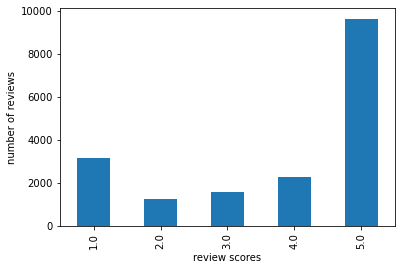

In [2]:
# retrieve dataframe from db
df_rev = utils.get_df('review')
df_info = utils.get_df("info")
df_meta = utils.get_df("meta")
# df of metascore and itunes rating
df_scores = df_info.merge(df_meta,on="name")
# merge all 
df = df_scores.merge(df_rev,on=["name","app_id"])
# plot review score distribution
df_rev['review_score'].value_counts().sort_index().plot(kind='bar',xlabel='review scores',ylabel='number of reviews')
df[['name','score','rating','review_score','title','body']].head()

- "score" is the metascore for the game scrapped from metacritcs.com

- "rating" is the overall(average) user review score on iTunes

- "review_score" is the score of a specific review whose title and body are followed in the same row

## Data Cleaning and Sentiment Labeling:
1. Simple label a review by corresponding review score: score [1,2,3] are considered as "bad" and [4,5] as "good"
2. Only keep English chars in review.
3. If a review become empty after cleaning(usually when reviewer is satisfied with the title), fill review with the title.

In [3]:
# create labels for the individual reviews
df["negative_review"] = df["review_score"].apply(lambda x: 1 if x <= 3 else 0)
df_rev = df[["name","review_score","title","body","negative_review"]]
df_rev.head()

,name,review_score,title,body,negative_review
0,World of Goo,1.0,Wow,Used to love this game and bought it somewhat ...,1
1,World of Goo,5.0,Coooooool,I remember playing this game as a kid. I would...,0
2,World of Goo,1.0,Refund,I would like a refund for this game I paid $5 ...,1
3,World of Goo,4.0,Awesome!,"Please, add 2020 iPad Pro resolution support",0
4,World of Goo,4.0,More levels!,"Can you let us make custom levels, or even add...",0


In [4]:
'''this cell could be slow, please be patient:)'''
nltk.download('wordnet')
# use wordnet to tag words
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
nltk.download('averaged_perceptron_tagger')
def clean_text(text):
    text = text.lower()
    text = eng(text)
    # remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stopwords
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# KEEP ONLY ENGLISH CHAR
def eng(text):
    text = re.sub("([^\x00-\x7F])+"," ",text)
    return text

# clean Data
df_rev["body_clean"] = df_rev["body"].apply(lambda x: clean_text(x))
# fill empty reviews with cleaned title of the review
df_rev.body_clean.fillna(df_rev.title.apply(lambda x: clean_text(x)),inplace = True)
df_rev.drop(columns=["title"])
df_rev.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xulaijiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/xulaijiang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
<ipython-input-4-ea832a50d1b0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev["body_clean"] = df_rev["body"].apply(lambda x: clean_text(x))
/Users/xulaijiang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,name,review_score,title,body,negative_review,body_clean
0,World of Goo,1.0,Wow,Used to love this game and bought it somewhat ...,1,use love game buy somewhat recently maybe year...
1,World of Goo,5.0,Coooooool,I remember playing this game as a kid. I would...,0,remember playing game kid would come home scho...
2,World of Goo,1.0,Refund,I would like a refund for this game I paid $5 ...,1,would like refund game pay allow continue leav...
3,World of Goo,4.0,Awesome!,"Please, add 2020 iPad Pro resolution support",0,please add ipad pro resolution support
4,World of Goo,4.0,More levels!,"Can you let us make custom levels, or even add...",0,let make custom level even add level play year...


## Frequency Map and Word Cloud:

Total words in reviews: 18391


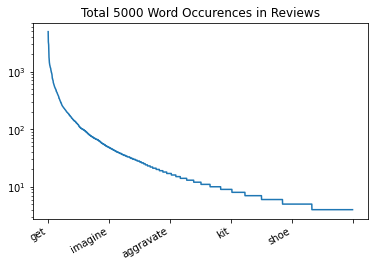

In [5]:
# Check word freq
freq_d = pd.Series(' '.join(df_rev['body_clean']).split()).value_counts()
freq_d = freq_d.drop(labels=['game','play'])
print(f"Total words in reviews: {freq_d.shape[0]}")
# Plot the words distribution
ax = freq_d.iloc[:5000].plot(kind='line',use_index=True,title="Total 5000 Word Occurences in Reviews",logx=False, logy=True)
ax.figure.autofmt_xdate()

In [6]:
# word cloud plot func
def show_wordcloud(data, bgc = 'white', stopwords = None, title = None):
    wordcloud = WordCloud(
        background_color = bgc,
        max_words = 150,
        stopwords = stopwords,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

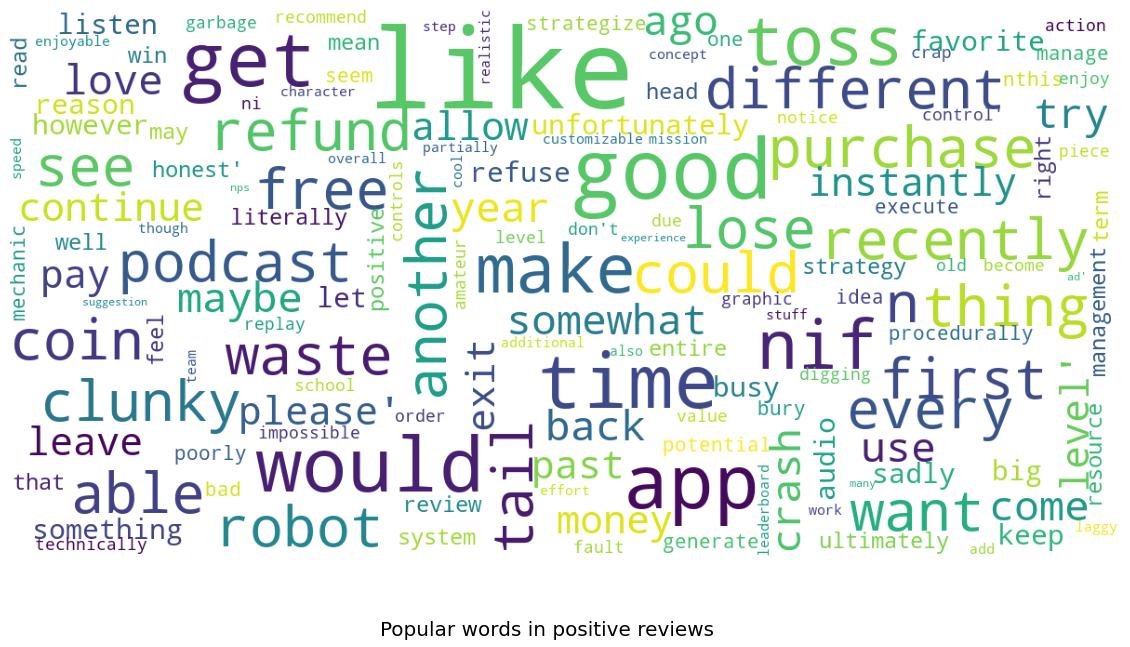

In [7]:
# plot word cloud of postive reviews
show_wordcloud(df_rev.loc[df_rev.negative_review==1]["body_clean"].values,stopwords=['game','play','buy'],title="Popular words in positive reviews")

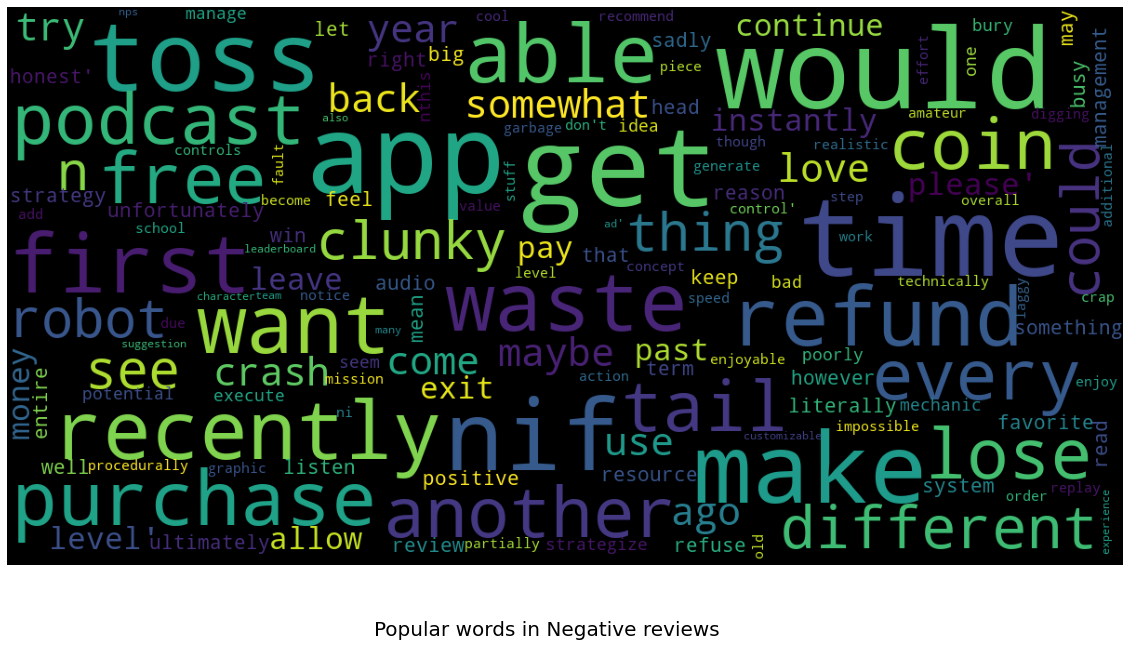

In [8]:
# plot word cloud of negative reviews
show_wordcloud(df_rev.loc[df_rev.negative_review==1]['body_clean'].values,bgc="black",stopwords=['good','game','play','like','buy'],title="Popular words in Negative reviews")

# Sentimental Analysis on Cleaned Data

In [9]:
# sentiment columns
nltk.download("vader_lexicon")

sid = SentimentIntensityAnalyzer()
df_rev["sentiments"] = df_rev["body_clean"].apply(lambda x: sid.polarity_scores(x))
df_rev = pd.concat([df_rev,df_rev['sentiments'].apply(pd.Series)],axis=1).drop(columns=['sentiments'])
df_rev.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/xulaijiang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-9-65204e37e4a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rev["sentiments"] = df_rev["body_clean"].apply(lambda x: sid.polarity_scores(x))


,name,review_score,title,body,negative_review,body_clean,neg,neu,pos,compound
0,World of Goo,1.0,Wow,Used to love this game and bought it somewhat ...,1,use love game buy somewhat recently maybe year...,0.105,0.547,0.348,0.7351
1,World of Goo,5.0,Coooooool,I remember playing this game as a kid. I would...,0,remember playing game kid would come home scho...,0.000,0.642,0.358,0.6908
2,World of Goo,1.0,Refund,I would like a refund for this game I paid $5 ...,1,would like refund game pay allow continue leav...,0.224,0.539,0.237,0.0772
3,World of Goo,4.0,Awesome!,"Please, add 2020 iPad Pro resolution support",0,please add ipad pro resolution support,0.000,0.444,0.556,0.6124
4,World of Goo,4.0,More levels!,"Can you let us make custom levels, or even add...",0,let make custom level even add level play year...,0.000,0.743,0.257,0.5423


#### Observations:
- Pre-trained sentimental model gives "neg","neu","pos" and "compound" estimates for each review, correponding the "negativity","neutrality","positivity" and "overall sentiment" in the review. 
- The range of "neg","neu" and "pos" is [0,1], but "compound" is ranged in [-1,1].
- Notice that "neg","neu","pos" always sum to 1 for each review, 2 out of 3 parameters will be enough for classification/ regression tasks.

In [10]:
# add number of characters column
df_rev["nb_chars"] = df_rev["body_clean"].apply(lambda x: len(x))

# add number of words column
df_rev["nb_words"] = df_rev["body_clean"].apply(lambda x: len(x.split(" ")))

In [11]:
# sort df by the highest positive sentiment reviews 
df_rev[df_rev["nb_words"] >= 4].sort_values("pos", ascending = False)[["body", "pos"]].head(10)

,body,pos
9990,So cute and sweet and relaxing and fun :),1.000
16816,Pretty good for Casual play,1.000
13945,It's easy and fun. Me and my friend played it ...,1.000
1919,LOVE LOVE LOVE LOVE LOVE LOVE LOVE LOVE,1.000
1035,I just love it love it it's awesome and great,1.000
7584,"The game is nice, nice good, good is great and...",0.959
8522,I love it super fun and great tracks,0.939
16101,Love it. Super fun and great design.,0.939
12232,The graphics are amazing! If you like the orig...,0.938
15254,Fantastic game. Love it super fun,0.938


As we can see, the nltk sentimental analyzer performed very well. Reviews are classified/ regression very accurately in terms of "how positive a review is".

## "Sentiment Measure": 
Simple average scaled "compound" score in to the range of iTunes ratings.
Because $compound\in[-1,1]$, $iTunes\ score\in[1,5]$:

<center>$\mathbf{Mc}$ = $Mean_{game}$ (2*$compound$ + 3)<center>

In [12]:
# calculate mean grouped by game name
temp = df_rev.groupby('name', as_index=False)['compound'].mean()
temp['Mc'] = temp['compound'].apply(lambda x:2*x+3)
# merge itunes score and metascore into table
temp = temp.merge(df_info[['name','rating']],on='name').merge(df_meta,on='name').drop(columns=['compound'])
temp.head()

,name,Mc,rating,score
0,KingdomConquest,3.549924,4.58960,90
1,Shift 2,3.766764,4.59748,87
2,7 Mages,4.112117,4.00000,90
3,80 Days,4.275044,4.33850,88
4,99 Bricks Wizard Academy,3.887792,4.66854,86


In [13]:
def lin_reg(x,y):
    model = LinearRegression(fit_intercept=True)
    # regress
    model.fit(x, y)
    fig, ax = plt.subplots()
    ax.scatter(x, y, c = 'red',label = 'data points',alpha=0.3)
    # show Model within range of x
    xfit = np.linspace(start =1,stop= 5,num=1000).reshape(-1,1)
    yfit = model.predict(xfit)
    ax.plot(xfit, yfit,c = 'blue',label = 'regression model')
    ax.legend()
    # compute mean squared error
    from sklearn.metrics import mean_squared_error
    print(f"Mean squared error of regression is: {mean_squared_error(y,model.predict(x))}")
    plt.show()

Mean squared error of regression is: 0.2523440414159133


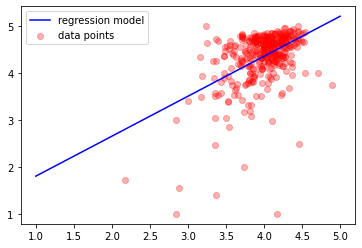

In [14]:
# regression with iTunes Score
lin_reg(np.array(temp.Mc).reshape(-1,1),temp.rating)

As we can see, the mean compound sentiment measure(x-axis) fits very well with average iTunes score(y-axis). But notice that most of the outliers are far __below__ the regression line, which suggests that many reviewers gave __low scores__ to the game despite their reviews have more __positive__ sentiment.

The reason behind such distribution could be complicated:
1. As we have seen from the raw score distribution, online reviews tend to be biased to "very good" or "extreme bad"._(reference 2 mentioned more in details)_
2. The nltk.vader sentimental analysis model is not completely accurate. For example, we can see a few positively marked words in negative reviews, such as "like", "free". Because the context of a word in a sentence has great affect on the sentiment of the word, even pretrained NLP models cannot achieve 100% on the classification.
3. Linear assumption between sentiment measure and average rating is incorrect. (very plausible, since sentiments sometimes don't "scale" linearly to facts)

Mean squared error of regression is: 6.966342681107617


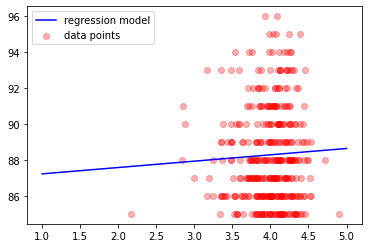

In [15]:
# regression with metascore
lin_reg(np.array(temp['Mc'].values).reshape(-1,1),temp.score)

Since metascores are mainly based on popular critics opinion, it's not surprising to see that sentimental measure from users doesn't fit/correlate well with the metascore

## How Review Bias is Related to Game Genre?
Now that we know there's indeed a bias in iTunes review, one may wonder how wild is the bias expressed among different categories of the game. For example, "Are gamers more mad at paid games than free games?", "Are gamers of action games more salty than others?", etc... 

In [16]:
# main categories of games
cat = ['Action','Adventure','Sports','Role Playing','Strategy']
temp = temp.merge(df_info[['name','genre','price']],on='name')
temp.head()

,name,Mc,rating,score,genre,price
0,KingdomConquest,3.549924,4.58960,90,"['Games', 'Strategy', 'Role Playing']",0.00
1,Shift 2,3.766764,4.59748,87,"['Games', 'Adventure']",0.00
2,7 Mages,4.112117,4.00000,90,"['Games', 'Adventure', 'Role Playing']",0.00
3,80 Days,4.275044,4.33850,88,"['Games', 'Strategy', 'Books', 'Adventure']",4.99
4,99 Bricks Wizard Academy,3.887792,4.66854,86,"['Games', 'Puzzle', 'Casual']",0.00


In [17]:
# comprehesion is too long, a simple func return scores of given category
def score_cat(temp,key):
    return temp.loc[temp["genre"].str.contains(key),["Mc","rating"]]

Number of action games: 125
Mean squared error of regression is: 0.1808239904989391


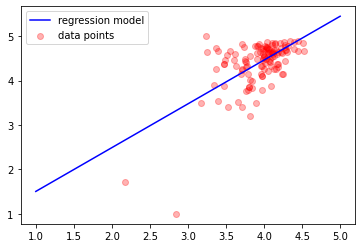

In [18]:
# action games
print(f"Number of action games: {score_cat(temp,cat[0]).shape[0]}")
lin_reg(np.array(score_cat(temp,cat[0]).Mc).reshape(-1,1),score_cat(temp,cat[0]).rating)

Number of adventure games: 125
Mean squared error of regression is: 0.17128854578381544


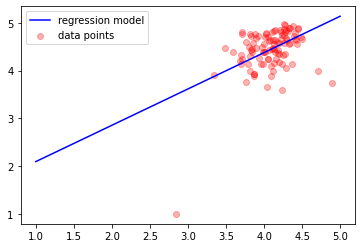

In [19]:
# adventure games
print(f"Number of adventure games: {score_cat(temp,cat[0]).shape[0]}")
lin_reg(np.array(score_cat(temp,cat[1]).Mc).reshape(-1,1),score_cat(temp,cat[1]).rating)

Number of role playing games: 63
Mean squared error of regression is: 0.09010635046320802


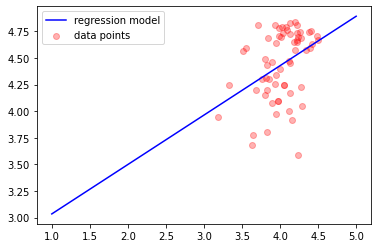

In [20]:
# role playing games
print(f"Number of role playing games: {score_cat(temp,cat[3]).shape[0]}")
lin_reg(np.array(score_cat(temp,cat[3]).Mc).reshape(-1,1),score_cat(temp,cat[3]).rating)

Number of sports games: 22
Mean squared error of regression is: 0.13016806781516818


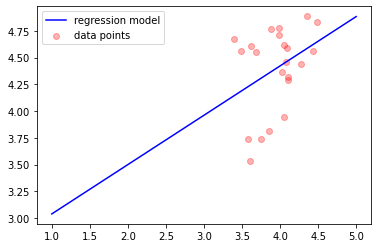

In [21]:
# sports games
print(f"Number of sports games: {score_cat(temp,cat[2]).shape[0]}")
lin_reg(np.array(score_cat(temp,cat[2]).Mc).reshape(-1,1),score_cat(temp,cat[2]).rating)

Number of strategy games: 67
Mean squared error of regression is: 0.23755779903343197


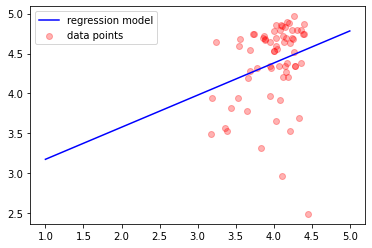

In [22]:
# strategy games
print(f"Number of strategy games: {score_cat(temp,cat[4]).shape[0]}")
lin_reg(np.array(score_cat(temp,cat[4]).Mc).reshape(-1,1),score_cat(temp,cat[4]).rating)

#### Observations:
- All game reviews tends to cluster top right, meaning reviewers who relatively like the game tend to give a higher score than their sentimental measure. 
- "action","adventure" game reviews in general fit well with a linear Mc-rating regression model. 
- "role playing", "sports" and "strategy" games have stronger bias (more outliers below regression line).

# Conclusion: 
The average review score on iTunes is quite reliable on expressing players' sentiments to a game. Be aware that not all games with higher scores offer better experience, since most reviews avaiable are to some extent biased to higher scores on iTunes. Furthermore, role playing, sports and strategy games could actually offer good experiences despite having a low score, because reviews in these categories tend to be biased to lower scores in general.

## Skills I wish I had while doing the project:
1. Modeling: I was often confused about which model should I implement if I want to show a certain relation. 
2. Visualization: the only visualization library I felt familiar with was mathplotlib, which doesn't have the funciest illustrations. I searched NLP projects online and saw how good wordcloud is at showing important texts from a paragraph.

## Future Expansion to the Poject:
1. I'll try to train a NLP model on the data and compare it preformance over the pre-trained one.
2. I'll try to scrape more reviews from each game to get a better estimate of the sentiment measure. I have to limit the number of reviews due to computational deficiency on my laptop as well as the API rate limit by Apple. 


# References:
https://arxiv.org/pdf/cs/0205028.pdf <br>
https://www.sciencedirect.com/science/article/pii/S0167923617300428